### So here we are using the data which we generated in the last part

![recommend](https://miro.medium.com/max/2560/1*dOM8OeGZq6FkquXQq-l7HA.jpeg)

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/generated-user-data-for-recommendation/file3.csv


In [0]:
df = pd.read_csv('/kaggle/input/generated-user-data-for-recommendation/file3.csv')

In [0]:
df.head()

,UserId,SessionId,ArticleId_served,rating
0,0,1,0,2
1,0,1,1,1
2,0,1,2,2
3,0,1,3,5
4,0,1,4,5


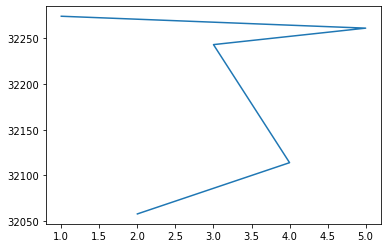

In [0]:
df['rating'].value_counts()[:50].plot()

SURPISE - is a Python scikit building and analyzing recommender systems that deal with explicit rating data.

The name SurPRISE (roughly :) ) stands for Simple Python RecommendatIon System Engine.

In [0]:
from surprise import Reader
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split


In [0]:
reader = Reader()

In [0]:
data = Dataset.load_from_df(df[['UserId', 'ArticleId_served', 'rating']], reader)

In [0]:
dataset = data.build_full_trainset()
print('Number of users: ',dataset.n_users,'\n')
print('Number of items: ',dataset.n_items)

Number of users:  4830 

Number of items:  4831


### With the Surprise library, we will benchmark the following algorithms:

In [0]:
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import BaselineOnly
from surprise import CoClustering

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.441145,0.619702,0.673646
SVD,1.466417,13.307138,1.015819
SVDpp,1.486014,116.085068,5.172688
CoClustering,1.546841,5.809843,0.919060
KNNBaseline,1.667830,2.570384,4.113992
KNNBasic,1.672272,1.816061,3.723920
KNNWithMeans,1.675658,1.990167,4.135979
NMF,1.686610,15.406493,0.813716
NormalPredictor,1.868847,0.343571,0.715170


> There are few more like coclustering , slopeone, KNNWithZScore . feel free to use them as well 

## SVD

In [0]:
from surprise.model_selection import GridSearchCV


lr_all --> learning rate for all parameters

reg_all --> The regularization term for all parameters

#### Tuning SVD parameters with GridSearchCV

In [0]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# best RMSE score
print(gs.best_score['mae'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

# combination of parameters that gave the best MAE score
print(gs.best_params['mae'])

1.4193677771715443
1.2179176587999363
{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.6}
{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.6}


> After tuning rmse reduced to 1.419594

In [0]:
svd = SVD(n_factors= 50, reg_all=0.05)
svd.fit(dataset)

PREDICTIONS

In [0]:
svd.predict(2,4)

Prediction(uid=2, iid=4, r_ui=None, est=2.3869416538479182, details={'was_impossible': False})

In [0]:
svd.predict(2,5)

Prediction(uid=2, iid=5, r_ui=None, est=2.074086574148923, details={'was_impossible': False})

In [0]:
r = df['ArticleId_served'].unique()
len(r)
list_of_articles = r.tolist()
list_of_articles[:5]

rec = []
for i in list_of_articles:
    predicted_rating = svd.predict(2, i)
    rec.append(predicted_rating)
    
rec[:10]    

[Prediction(uid=2, iid=0, r_ui=None, est=2.6150298260481084, details={'was_impossible': False}),
 Prediction(uid=2, iid=1, r_ui=None, est=2.217782131785083, details={'was_impossible': False}),
 Prediction(uid=2, iid=2, r_ui=None, est=2.546301260997003, details={'was_impossible': False}),
 Prediction(uid=2, iid=3, r_ui=None, est=2.3863461119484284, details={'was_impossible': False}),
 Prediction(uid=2, iid=4, r_ui=None, est=2.3869416538479182, details={'was_impossible': False}),
 Prediction(uid=2, iid=5, r_ui=None, est=2.074086574148923, details={'was_impossible': False}),
 Prediction(uid=2, iid=6, r_ui=None, est=2.443128987976906, details={'was_impossible': False}),
 Prediction(uid=2, iid=7, r_ui=None, est=2.663284537536007, details={'was_impossible': False}),
 Prediction(uid=2, iid=8, r_ui=None, est=1.9484658695248593, details={'was_impossible': False}),
 Prediction(uid=2, iid=9, r_ui=None, est=2.7768372139419015, details={'was_impossible': False})]

## BaselineOnly

#### Tuning BaselineOnly parameters with GridSearchCV

In [0]:
param_grid = {'bsl_options':{'method': ['als','sgd'],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}}

# bsl_options = {'method': ['als','sgd'],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
bsl_algo = BaselineOnly()

In [0]:
gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

> After tuning rmse reduced to 1.4265558

In [0]:
bsl_options = {'method': 'sgd', 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}
algo = BaselineOnly(bsl_options=bsl_options)

algo.fit(dataset)

Estimating biases using sgd...


PREDICTIONS

In [0]:
algo.predict(2,4)

Prediction(uid=2, iid=4, r_ui=None, est=2.562330284651921, details={'was_impossible': False})

In [0]:
algo.predict(2,5)

Prediction(uid=2, iid=5, r_ui=None, est=2.4186013549243226, details={'was_impossible': False})

In [0]:
r = df['ArticleId_served'].unique()
len(r)
list_of_articles = r.tolist()
list_of_articles[:5]

[0, 1, 2, 3, 4]

In [0]:
rec = []
for i in list_of_articles:
    predicted_rating = algo.predict(2, i)
    rec.append(predicted_rating)

In [0]:
rec[:10]

[Prediction(uid=2, iid=0, r_ui=None, est=2.708472121464236, details={'was_impossible': False}),
 Prediction(uid=2, iid=1, r_ui=None, est=2.615852436554692, details={'was_impossible': False}),
 Prediction(uid=2, iid=2, r_ui=None, est=2.7177441385545906, details={'was_impossible': False}),
 Prediction(uid=2, iid=3, r_ui=None, est=2.6507241809536355, details={'was_impossible': False}),
 Prediction(uid=2, iid=4, r_ui=None, est=2.562330284651921, details={'was_impossible': False}),
 Prediction(uid=2, iid=5, r_ui=None, est=2.4186013549243226, details={'was_impossible': False}),
 Prediction(uid=2, iid=6, r_ui=None, est=2.7027730301506567, details={'was_impossible': False}),
 Prediction(uid=2, iid=7, r_ui=None, est=2.7497372044376136, details={'was_impossible': False}),
 Prediction(uid=2, iid=8, r_ui=None, est=2.282391241175862, details={'was_impossible': False}),
 Prediction(uid=2, iid=9, r_ui=None, est=2.782657240943323, details={'was_impossible': False})]